In [1]:
import tensorflow as tf
from train import build_lstm_forward, build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
from scipy.misc import imread
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
idl = al.parse('./data/brainwash/brainwash_val.idl')

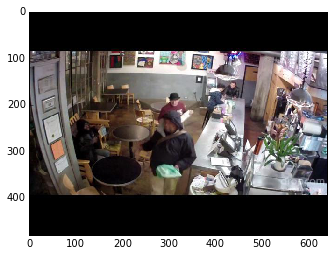

In [3]:
anno = idl[350]
img = imread('./data/brainwash/%s' % anno.imageName)
plt.imshow(img)

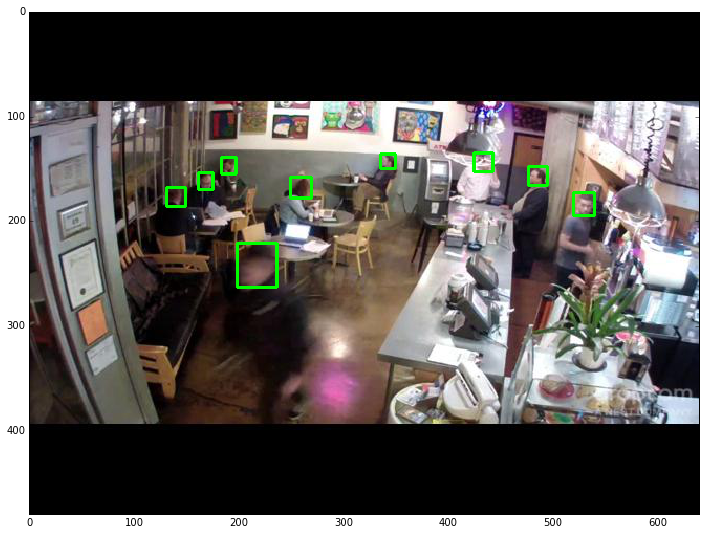

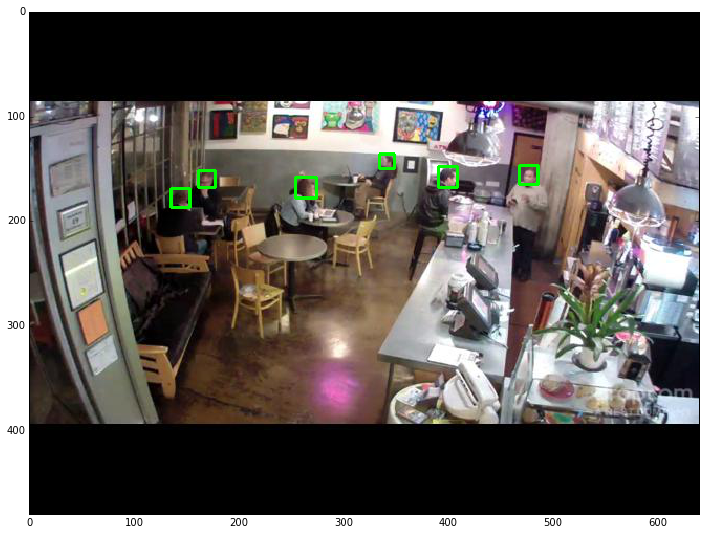

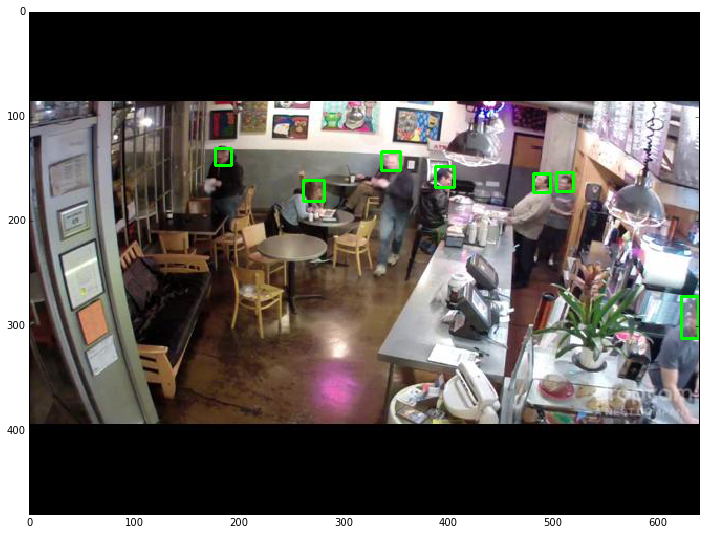

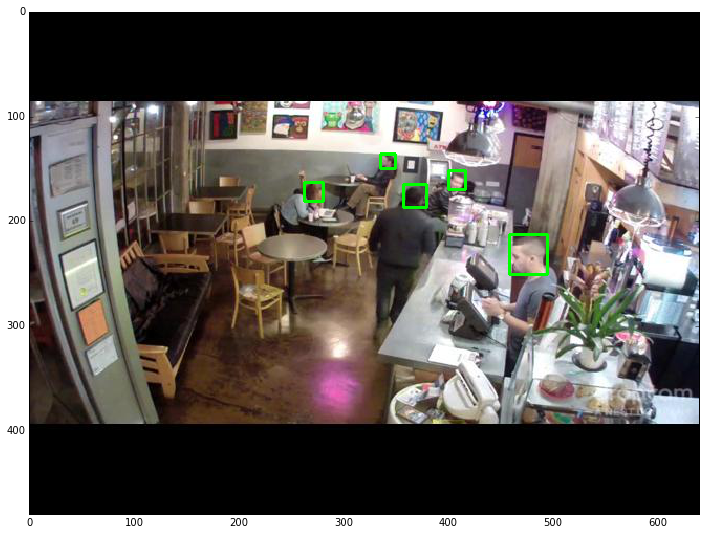

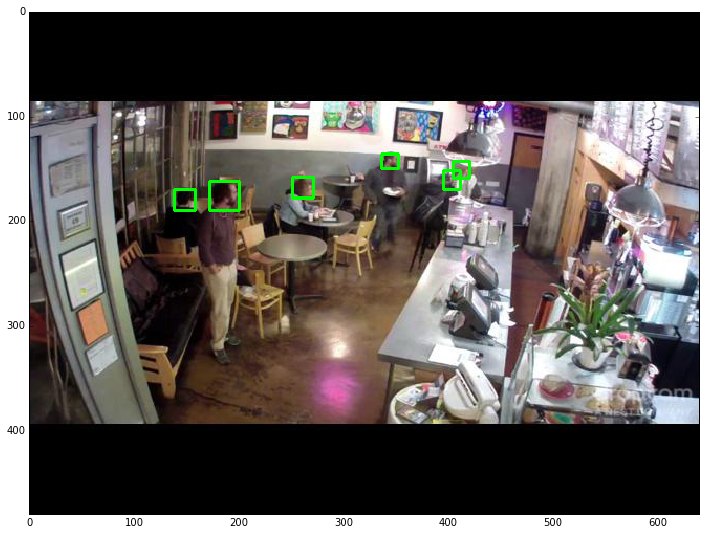

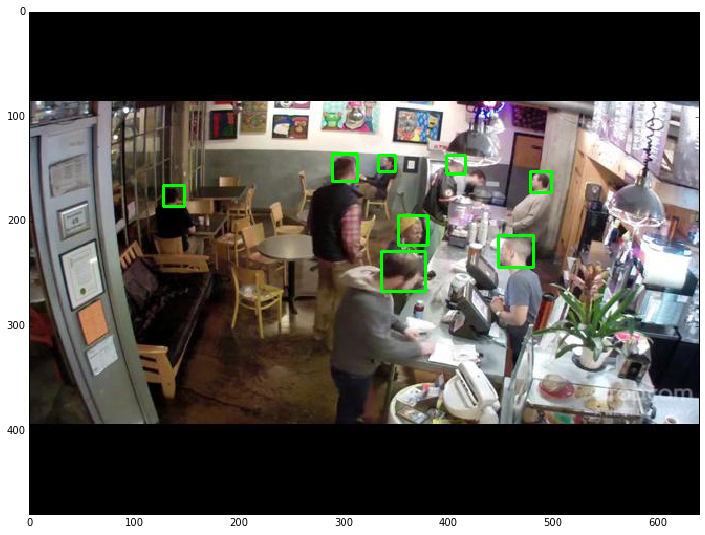

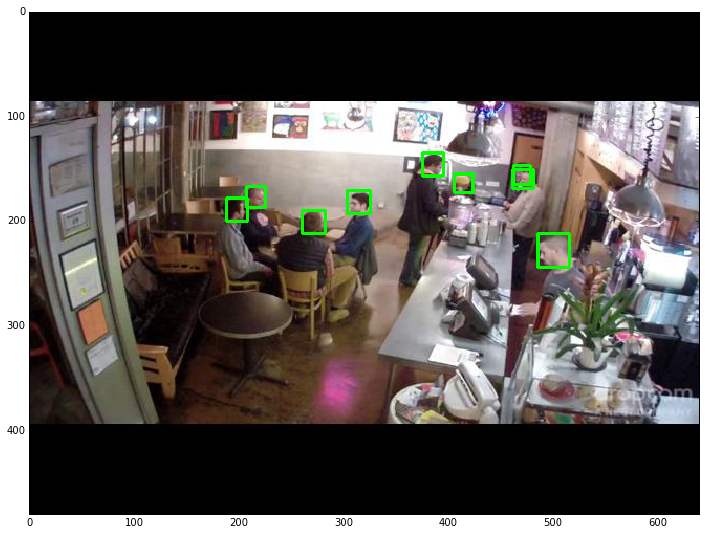

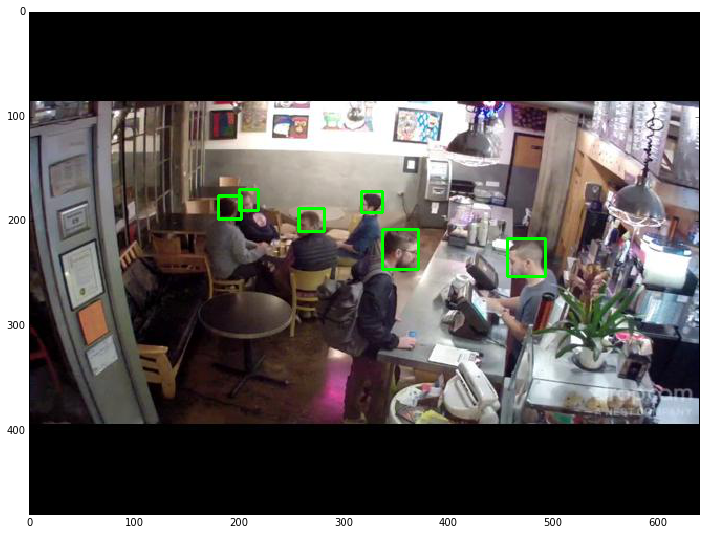

In [6]:
with open('./hypes/lstm2_100decay.json', 'r') as f:
    H = json.load(f)
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    if H['arch']['use_lstm']:
        saver.restore(sess, 'output/lstm2_100decay_2016_02_21_17.53/save.ckpt-320000')
    else:
        saver.restore(sess, 'output/default_2016_02_21_17.53/save.ckpt-100000')

    for i in range(0, 50, 7):
        anno = idl[i]
        img = imread('./data/brainwash/%s' % anno.imageName)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        new_img = add_rectangles([img], np_pred_confidences, np_pred_boxes,
                                 H["arch"], use_stitching=True, rnn_len=H['arch']['rnn_len'], min_conf=0.3)

        fig = plt.figure(figsize=(12, 12))
        plt.imshow(new_img)